In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.util import ngrams 

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


def evaluate_model(y_test, y_pred):
   accuracy = np.around(metrics.accuracy_score(y_test, y_pred),3)
   precision = np.around(metrics.precision_score(y_test, y_pred, average='macro'),3)
   recall = np.around(metrics.recall_score(y_test, y_pred, average='macro'),3)
   f1_score = np.around(metrics.f1_score(y_test, y_pred, average='macro'),3)
   print(classification_report(y_test, y_pred))  
   print('accuracy: %s' % accuracy)
   print('precision: %s' % precision)
   print('recall: %s' % recall)
   print('f1_score: %s' % f1_score)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score}

def vader_sentiment(doc):
   analyzer= SentimentIntensityAnalyzer()
   score = analyzer.polarity_scores(doc)['compound']
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def textblob_sentiment(doc):
   from textblob import TextBlob
   score = TextBlob(doc).sentiment.polarity
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def plot_confusion_matrix(y_test, y_pred):
   from sklearn.preprocessing import MinMaxScaler
   from sklearn.metrics import classification_report, confusion_matrix
   
   labels = np.unique(y_test)
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print(cm_df)
   cmap = sns.color_palette("OrRd", 1000)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def vizualize_classification(y_test, y_pred):
   from sklearn.metrics import classification_report, confusion_matrix
   labels = np.unique(y_test)
   cmap = sns.color_palette("OrRd", 1000)
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
   fig.suptitle('Vizualizing classifier')
   
   ax = sns.countplot(x=y_pred, hue=y_test, order=labels, ax=ax1)
   
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print('Confusion Matrix: \n', cm_df)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g', ax=ax2)
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   evaluate_model(y_test, y_pred)
   
def textblob_NBClassifier(doc):
   blob = TextBlob(doc, classifier=cl)
   return blob.classify()

In [3]:
print("")
print("Starting immigration data processing...")
print("")
start = datetime.now()

#Load dataframe
immigration_df = pd.read_csv('data/tweet_immigration_db.csv')
# vectorize hashtags
immigration_df.dropna(subset=['hashtags'], inplace=True)
immigration_df.loc[:, 'hashtags'] = immigration_df['hashtags'].apply(lambda x: x.replace('[','').
                                                                                 replace(']','').
                                                                                 replace('\'','').
                                                                                 split(','))

# Tokenize text
immigration_df['tokenized_features'] = immigration_df['text'].apply(tweet_processor.tweet_pipeline)
# combine 'tokenized_features', 'keyword', 'hashtags' columns
immigration_df['col_combination'] = immigration_df['tokenized_features'] + \
                                    immigration_df['keyword'].apply(lambda x: [x]) + \
                                    immigration_df['hashtags']
print('Finished in: ', datetime.now()-start)

immigration_df.head()


Starting immigration data processing...



/home/arvartho/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,7,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Finished in:  0:00:29.124709


,keyword,timestamp,username,screen_name,user_location,user_description,user_followers_count,user_friends_count,user_favourites_count,text,place,coordinates,favorite_count,hashtags,retweet_count,tokenized_features,col_combination
0,immigration,2020-03-10 20:02:02.000000000,Eva Almea,AlmeaEva,"Boston,MA",NaN,2,53,3,RT @HillaryClinton: Any human being can spread...,NaN,NaN,0,[],2394,"[human, spread, virus, whether, citizen, perma...","[human, spread, virus, whether, citizen, perma..."
1,immigration,2020-03-10 20:02:02.000000000,Richard Schumacher,rspyboy,"Meridian, Idaho","RN,retired; husband; father; grandfather; Holy...",240,536,41288,RT @Imm_Judges_NAIJ: EOIR has ordered immigrat...,NaN,NaN,0,[],8995,"[EOIR, ordered, immigration, court, staff, rem...","[EOIR, ordered, immigration, court, staff, rem..."
2,immigration,2020-03-10 20:02:02.000000000,Ashlea Kosikowski 🎙🎥,AshleaOnAir,"Wilmington, NC","@WECTNews First at Four & News at 10 Anchor, M...",5284,4196,6171,RT @FridaGhitis: Trump administration orders i...,NaN,NaN,0,[coronavirus],1120,"[Trump, administration, orders, immigration, o...","[Trump, administration, orders, immigration, o..."
3,immigration,2020-03-10 20:02:02.000000000,Demeralda,demeralda,"Michigan, USA",Political junkie. 6th generation Michigander. ...,2256,4967,257124,RT @bulldoghill: She had family in the U.S. an...,NaN,NaN,0,[],5,"[family, US, passed, credible, fear, interview...","[family, US, passed, credible, fear, interview..."
4,immigration,2020-03-10 20:02:02.000000000,Caroline #BoycottNRA🚫,carnmcgrath,"Marietta, GA",sometimes when things are falling apart they m...,4524,5002,108407,RT @BradBeauregardJ: The Trump administration ...,NaN,NaN,0,[],19,"[Trump, administration, wants, immigrants, cor...","[Trump, administration, wants, immigrants, cor..."


## Pool-based Active Learning

Combine Pool-based Active learning with Query by Committee learning

---

**Pool-Based Active Learning:** samples are chosen from a pool of unlabeled data for the purpose of labeling.

Here are the steps of pool-based sampling:
1. Divide the data to a ‘pool’ and a test-set
2. Select ‘k’ samples from the pool for the initial train-set and label them, the remaining data will be the validation-set
3. Normalize all the sets
4. Train the Model using the train-set, with balanced weights.
5. Use the trained model with the validation-set, get probabilities per sample.
6. Use the trained model with the test-set, get performance measures.
7. Select ‘k’ most-informative samples based on per-sample-probabilities, i.e., those that the model was most uncertain about regarding their labelling.
8. Move these ‘k’ samples from the validation set to the train-set and query their labels.
9. Inverse normalization for all the data-sets
10. Stop according to the stop criterion, otherwise go to 3.


---

**Query by Committee learning:** create an ensable of predictions and query the values of they disagree the most
Predictions:
* Textblob
* Bernoulli NB
* Multinomial NB


Load annotated data from **pool-based learning**

In [4]:
annotation_df = pd.read_csv('data/annotation.csv', sep=',', names=['id', 'textblob_sentiment', 'sentiment'])
annotation_df.head()

,id,textblob_sentiment,sentiment
0,20469,positive,positive
1,77610,positive,positive
2,38127,positive,neutral
3,17558,positive,neutral
4,21043,positive,negative


,keyword,timestamp,username,screen_name,user_location,user_description,user_followers_count,user_friends_count,user_favourites_count,text,place,coordinates,favorite_count,hashtags,retweet_count,tokenized_features,col_combination,sentiment,tokenized_textblob_sentiment,tokenized_vader_sentiment
20469,refugee,2020-03-19 14:22:19.000000000,ElizabethAllen,ElizabethAllen,London,Campaigns Director at Orion Books @orionbooks ...,1977,1968,999,RT @wnbooks: Did you know that Syrian refugee ...,NaN,NaN,0,[],1,"[know, Syrian, refugee, children, young, six, ...","[know, Syrian, refugee, children, young, six, ...",positive,positive,positive
77610,immigration,2020/04/09 01:40:00,ANGY,AskAngy,🇨🇴 🌈NY,Co-Director @nysylc\nPeabody Award Winning doc...,7531,993,1223,RT @NYSYLC: 🥰distribution of emergency funds c...,NaN,NaN,0,"[immigrant, covid19]",1,"[🥰, distribution, emergency, funds, continues,...","[🥰, distribution, emergency, funds, continues,...",positive,positive,positive
38127,migrant,2020/03/30 21:50:00,ganapathy hegde,ganapathyhegde6,Mangalore,Retired UAE armed forces doctor,28,82,1718,@CMOKerala @PMOIndia \n\nPeople in high posts ...,NaN,NaN,0,[],0,"[People, high, posts, careful, talking, migran...","[People, high, posts, careful, talking, migran...",neutral,positive,positive
17558,immigration,2020-03-18 06:01:39.000000000,kcbyrne,kcbyrne,Chicago,City to my core. Retweets are just retweets.,501,375,70991,RT @DOJ_EOIR: Effective March 18 all non-detai...,NaN,NaN,0,[],32,"[Effective, March, non-detained, hearings, pos...","[Effective, March, non-detained, hearings, pos...",neutral,positive,positive
21043,immigration,2020-03-19 19:51:46.000000000,WAVEBOY-Intrntl.,Waveboyy_,"New Jersey, USA",On The Wave of Culture,19,32,335,@dianap652 The immigration system ain't broken...,NaN,NaN,0,[],0,"[dianap, immigration, system, ai, not, broken,...","[dianap, immigration, system, ai, not, broken,...",negative,positive,positive


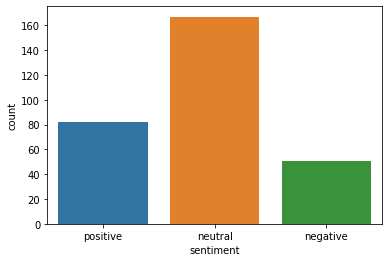

In [5]:
# Create annotated dataset
sampled_immigration_df = immigration_df.loc[annotation_df['id'].values, :]

# Active learning annotation
sampled_immigration_df['sentiment'] = annotation_df['sentiment'].values

# TextBlob annotation
sampled_immigration_df['tokenized_textblob_sentiment'] = sampled_immigration_df['col_combination'].apply(lambda x: textblob_sentiment(' '.join(x)))
# VADER annotation
sampled_immigration_df['tokenized_vader_sentiment'] = sampled_immigration_df['col_combination'].apply(lambda x: vader_sentiment(' '.join(x)))


ax = sns.countplot(x="sentiment", data=sampled_immigration_df)
sampled_immigration_df.head()

In [6]:
# for i,sent,txt in zip(sampled_immigration_df.index.values,
#                       sampled_immigration_df['tokenized_textblob_sentiment'].values,
#                       sampled_immigration_df['text'].values):
#    print( i,sent,txt.replace('\n', ' '))

Feature selection of sample dataset and split to train and test set

In [7]:
# set the data and the target
X = immigration_df['col_combination'].apply(lambda x: ' '.join(x)).values
y = sampled_immigration_df['sentiment'].values

index_mapper = {index:i for i,index in enumerate(immigration_df.index.values)}
holdout_index = list(set(immigration_df.index.values) - set(sampled_immigration_df.index.values))

# TF-IDF text features
text_vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = text_vectorizer.transform(X)

# TF-IDF emoji features
em_vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = em_vectorizer.transform(X)

# Combine features 
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))

# split data to test and train sets
x_train_id, x_test_id, y_train, y_test = train_test_split(range(len(sampled_immigration_df.index.values)), y, test_size=0.2, random_state=42)
sample_X_combined = X_combined[[index_mapper[index] for index in sampled_immigration_df.index.values]]
holdout_set = X_combined[[index_mapper[index] for index in holdout_index]]

x_train = sample_X_combined[x_train_id]
x_test = sample_X_combined[x_test_id]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((240, 4824), (60, 4824), (240,), (60,))

#### VADER model

In [8]:
# pred_vader = sampled_immigration_df.iloc[x_test_id]['tokenized_vader_sentiment'].values

# immigration_df['tokenized_vader_sentiment'] = immigration_df['col_combination'].apply(lambda x: vader_sentiment(' '.join(x)))
# holdout_vader = immigration_df.loc[holdout_index, 'tokenized_vader_sentiment'].values
# vizualize_classification(y_test, pred_vader)

#### TextBlob model 

In [9]:
# pred_textblob = sampled_immigration_df.iloc[x_test_id]['tokenized_textblob_sentiment'].values

# immigration_df['tokenized_textblob_sentiment'] = immigration_df['col_combination'].apply(lambda x: textblob_sentiment(' '.join(x)))
# holdout_textblob = immigration_df.loc[holdout_index, 'tokenized_textblob_sentiment'].values
# vizualize_classification(y_test, pred_textblob)

### Committee query

Query on vader and textblob models for 300 random tweets that they disagree

In [10]:
# import random

# diff_ids = np.where(holdout_textblob != holdout_vader)[0].tolist()
# random.seed(42)

# selected_ids = random.sample(diff_ids, 300)
# selected_df_ids = np.asarray(holdout_index)[selected_ids]
# for i,index in zip(selected_ids,selected_df_ids):
#    print(index,
#          immigration_df.loc[index, 'tokenized_vader_sentiment'],
#          immigration_df.loc[index, 'tokenized_textblob_sentiment'],
#           immigration_df.loc[index, 'text'].replace('\n', ' '),
#          immigration_df.loc[index, 'col_combination'])

Recreate annotated immigration dataset

In [11]:
annotation2_df = pd.read_csv('data/annotation2.csv', sep=',', names=['id', 'vader_sentiment', 'textblob_sentiment', 'sentiment'])
annotation2_df.head()

,id,vader_sentiment,textblob_sentiment,sentiment
0,14793,neutral,negative,positive
1,3335,negative,positive,positive
2,35882,negative,positive,positive
3,31850,neutral,positive,neutral
4,29002,negative,neutral,neutral


,keyword,timestamp,username,screen_name,user_location,user_description,user_followers_count,user_friends_count,user_favourites_count,text,place,coordinates,favorite_count,hashtags,retweet_count,tokenized_features,col_combination,sentiment,tokenized_textblob_sentiment,tokenized_vader_sentiment
20469,refugee,2020-03-19 14:22:19.000000000,ElizabethAllen,ElizabethAllen,London,Campaigns Director at Orion Books @orionbooks ...,1977,1968,999,RT @wnbooks: Did you know that Syrian refugee ...,NaN,NaN,0,[],1,"[know, Syrian, refugee, children, young, six, ...","[know, Syrian, refugee, children, young, six, ...",positive,positive,positive
77610,immigration,2020/04/09 01:40:00,ANGY,AskAngy,🇨🇴 🌈NY,Co-Director @nysylc\nPeabody Award Winning doc...,7531,993,1223,RT @NYSYLC: 🥰distribution of emergency funds c...,NaN,NaN,0,"[immigrant, covid19]",1,"[🥰, distribution, emergency, funds, continues,...","[🥰, distribution, emergency, funds, continues,...",positive,positive,positive
38127,migrant,2020/03/30 21:50:00,ganapathy hegde,ganapathyhegde6,Mangalore,Retired UAE armed forces doctor,28,82,1718,@CMOKerala @PMOIndia \n\nPeople in high posts ...,NaN,NaN,0,[],0,"[People, high, posts, careful, talking, migran...","[People, high, posts, careful, talking, migran...",neutral,positive,positive
17558,immigration,2020-03-18 06:01:39.000000000,kcbyrne,kcbyrne,Chicago,City to my core. Retweets are just retweets.,501,375,70991,RT @DOJ_EOIR: Effective March 18 all non-detai...,NaN,NaN,0,[],32,"[Effective, March, non-detained, hearings, pos...","[Effective, March, non-detained, hearings, pos...",neutral,positive,positive
21043,immigration,2020-03-19 19:51:46.000000000,WAVEBOY-Intrntl.,Waveboyy_,"New Jersey, USA",On The Wave of Culture,19,32,335,@dianap652 The immigration system ain't broken...,NaN,NaN,0,[],0,"[dianap, immigration, system, ai, not, broken,...","[dianap, immigration, system, ai, not, broken,...",negative,positive,positive


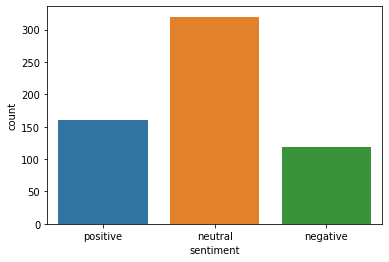

In [12]:
# Recreate annotated dataset
combined_ids = pd.concat([annotation_df['id'], annotation2_df['id']]).values
sampled_immigration_df = immigration_df.loc[combined_ids, :]

# Active learning annotation
sampled_immigration_df['sentiment'] = pd.concat([annotation_df['sentiment'], annotation2_df['sentiment']]).values

# TextBlob annotation
sampled_immigration_df['tokenized_textblob_sentiment'] = sampled_immigration_df['col_combination'].apply(lambda x: textblob_sentiment(' '.join(x)))
# VADER annotation
sampled_immigration_df['tokenized_vader_sentiment'] = sampled_immigration_df['col_combination'].apply(lambda x: vader_sentiment(' '.join(x)))


ax = sns.countplot(x="sentiment", data=sampled_immigration_df)
sampled_immigration_df.head()

Feature selection of sample dataset and split to train and test set

In [13]:
# set the data and the target
X = immigration_df['col_combination'].apply(lambda x: ' '.join(x)).values
y = sampled_immigration_df['sentiment'].values

index_mapper = {index:i for i,index in enumerate(immigration_df.index.values)}
holdout_index = list(set(immigration_df.index.values) - set(sampled_immigration_df.index.values))

# TF-IDF text features
text_vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = text_vectorizer.transform(X)

# TF-IDF emoji features
em_vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = em_vectorizer.transform(X)

# Combine features 
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))

# split data to test and train set
x_train_id, x_test_id, y_train, y_test = train_test_split(range(len(sampled_immigration_df.index.values)), y, test_size=0.1, random_state=42)
sample_X_combined = X_combined[[index_mapper[index] for index in sampled_immigration_df.index.values]]
holdout_set = X_combined[[index_mapper[index] for index in holdout_index]]

x_train = sample_X_combined[x_train_id]
x_test = sample_X_combined[x_test_id]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((540, 4824), (60, 4824), (540,), (60,))

#### Random Forest model


Starting OneVsRestClassifier RandomForestClassifier classifier...



/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/py

/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/arvartho/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Confusion Matrix: 
           negative  neutral  positive
negative         1        6         0
neutral          0       27         1
positive         0       23         2
              precision    recall  f1-score   support

    negative       1.00      0.14      0.25         7
     neutral       0.48      0.96      0.64        28
    positive       0.67      0.08      0.14        25

    accuracy                           0.50        60
   macro avg       0.72      0.40      0.35        60
weighted avg       0.62      0.50      0.39        60

accuracy: 0.5
precision: 0.716
recall: 0.396
f1_score: 0.345
Finished training in :  0:01:36.830072


NameError: name 'best_clf' is not defined

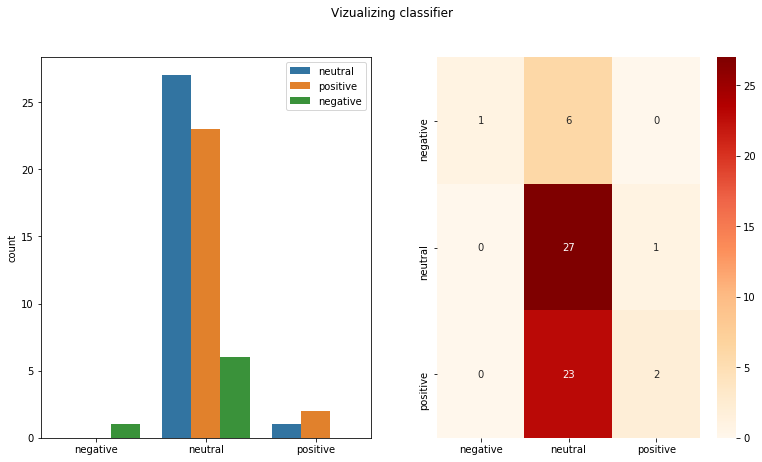

In [14]:
from sklearn.ensemble import RandomForestClassifier

print("")
print("Starting OneVsRestClassifier RandomForestClassifier classifier...")
print("")
start = datetime.now()
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=10, n_jobs=-1)))
            ])

parameters = [{
            'clf__estimator__criterion': ('gini', 'entropy'),
            'clf__estimator__max_depth': (17, 20, 25, 27, 30, 35),
            }]

scores = ['f1_macro', 'recall_macro', 'precision_macro', 'accuracy']

grid_search_cv = GridSearchCV(pipeline, parameters, scoring=scores, refit='accuracy', cv=5)
# print(grid_search_cv.get_params().keys())
grid_search_cv.fit(x_train, y_train)
best_rf_clf = grid_search_cv.best_estimator_

y_pred = best_rf_clf.predict(x_test)
predict_proba = best_rf_clf.predict_proba(x_test)
vizualize_classification(y_test, y_pred)
print('Finished training in : ', datetime.now()-start)
print(best_clf.get_params())
holdout_RandomForestClassifier = best_rf_clf.predict(holdout_set)
   

#### BernoulliNB model

In [ ]:
print("")
print("Starting OneVsRestClassifier BernoulliNB classifier...")
print("")
start = datetime.now()
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB()))
            ])

parameters = [{
            'clf__estimator__alpha': (0.001, 0.01, 0.4, 0.6, 0.8, 1),
            }]

scores = ['f1_macro', 'recall_macro', 'precision_macro', 'accuracy']

grid_search_cv = GridSearchCV(pipeline, parameters, scoring=scores, refit='accuracy', cv=5)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

y_pred = best_bernoulli_clf.predict(x_test)
predict_proba = best_bernoulli_clf.predict_proba(x_test)

vizualize_classification(y_test, y_pred)
print('Finished training in : ', datetime.now()-start)
print(best_clf.get_params())
holdout_BernoulliNB = best_bernoulli_clf.predict(holdout_set)
   

#### MultinomialNB

In [ ]:
print("")
print("Starting Bayes classifier...")
print("")
start = datetime.now()
pipeline = Pipeline([
                ('clf', MultinomialNB(class_prior=None))
            ])

parameters = [{
            'clf__alpha': (0.001, 0.01, 0.4, 0.6, 0.8, 1),
            'clf__fit_prior': (True, False)
            }]

scores = ['f1_macro', 'recall_macro', 'precision_macro', 'accuracy']

grid_search_cv = GridSearchCV(pipeline, parameters, scoring=scores, refit='accuracy', cv=5)
grid_search_cv.fit(x_train, y_train)
best_multinomial_clf = grid_search_cv.best_estimator_

y_pred = best_multinomial_clf.predict(x_test)

holdout_MultinomialNB = best_multinomial_clf.predict(holdout_set)
vizualize_classification(y_test, y_pred)

#### Logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

print("")
print("Starting LogisticRegression classifier...")
print("")
start = datetime.now()

lr_clf = LogisticRegressionCV(verbose=2, random_state=42, n_jobs=-1)
lr_clf.fit(x_train, y_train)
y_pred = lr_clf.predict(x_test)

print('Finished training in : ', datetime.now()-start) 
holdout_LogisticRegression = lr_clf.predict(holdout_set)
vizualize_classification(y_test, y_pred)

In [ ]:
for v in set(holdout_RandomForestClassifier):
   print(v, list(holdout_RandomForestClassifier).count(v))

In [ ]:
for v in set(holdout_BernoulliNB):
   print(v, list(holdout_BernoulliNB).count(v))

In [ ]:
for v in set(holdout_MultinomialNB):
   print(v, list(holdout_MultinomialNB).count(v))

In [ ]:
for v in set(holdout_LogisticRegression):
   print(v, list(holdout_LogisticRegression).count(v))

Exporting best performing model and finalizing immigration dataset

In [ ]:
# save model
model_filename = 'models/finalized_sentiment.model'
pickle.dump(best_bernoulli_clf, open(model_filename, 'wb'))
# save feature vector
feat_vector_filename = 'data/feature_vector.npz'
np.savez_compressed(feat_vector_filename, X_combined)

## TODO
* train models with airline dataset and validata with annotated dataset